In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
# import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
# from tensorflow_addons.optimizers import CyclicalLearningRate

In [4]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], False)

In [6]:
model_name = 'NASNet_Transfer_Mask_NOMEAN_1'

In [7]:
home = os.path.expanduser('~')
base = os.path.join('Datasets', 'ImageCLEF', 'Slice_Masks_331')

train_dir = os.path.join(home, base, 'train')
test_dir = os.path.join(home, base, 'test')

In [8]:
seed = 42
shuffle = True
inp_shp = (331, 331)
train_batch_size, val_batch_size = 16, 64

train_datagen = keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=inp_shp,
        batch_size=train_batch_size,
        seed=seed,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=shuffle
)

val_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=inp_shp,
        batch_size=val_batch_size,
        seed=seed,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=shuffle
)

Found 59888 images belonging to 5 classes.
Found 14847 images belonging to 5 classes.


In [9]:
input_shape = (331, 331, 3)

NASNet = tf.keras.applications.NASNetLarge(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None
)
NASNet.trainable = False
NASNet.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

separable_conv_2_bn_normal_left (None, 11, 11, 672)  2688        separable_conv_2_normal_left2_15[
__________________________________________________________________________________________________
separable_conv_2_bn_normal_righ (None, 11, 11, 672)  2688        separable_conv_2_normal_right2_15
__________________________________________________________________________________________________
normal_left3_15 (AveragePooling (None, 11, 11, 672)  0           normal_bn_1_15[0][0]             
__________________________________________________________________________________________________
normal_left4_15 (AveragePooling (None, 11, 11, 672)  0           adjust_bn_15[0][0]               
__________________________________________________________________________________________________
normal_right4_15 (AveragePoolin (None, 11, 11, 672)  0           adjust_bn_15[0][0]               
__________________________________________________________________________________________________
separable_

In [10]:
# CONv/FC -> BatchNorm -> ReLU(or other activation) -> Dropout -> CONV/FC -> ...

def get_model(base_model, input_shape):
    
    inputs = keras.Input(shape=input_shape)
    x = keras.applications.nasnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    
    x = layers.Conv2D(128, (3, 3), activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(rate=0.5)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(rate=0.5)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
#     x = layers.Conv2D(32, (3, 3), activation=None)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(alpha=0.1)(x)
#     x = layers.Dropout(rate=0.5)(x)
#     x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Flatten()(x)
    
#     x = layers.Dense(units=256, activation=None)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(alpha=0.1)(x)
#     x = layers.Dropout(rate=0.25)(x)

    x = layers.Dense(units=64, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(rate=0.25)(x)
    
    x = layers.Dense(units=5, activation=None)(x)
    output = layers.Softmax()(x)

    model = keras.Model(inputs=inputs, outputs=output, name=f'{model_name}')
    
    return model
#     model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

    

In [11]:
model = get_model(NASNet, input_shape)
model.summary()

Model: "NASNet_Transfer_Mask_NOMEAN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 331, 331, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Model)               (None, 11, 11, 4032)      84916818  
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 128)         4644992   
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 128)         512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 9

In [14]:
initial_learning_rate = 5e-3
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
    metrics=["accuracy"],
)

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"{model_name}.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8)


clr_triangular = CyclicLR(mode='triangular2')

history = model.fit(
            train_generator,
            epochs=64,
            steps_per_epoch=394,
            validation_data=val_generator,
#             validation_steps=29,
            shuffle=False,
            callbacks=[checkpoint_cb, early_stopping_cb]
)

Train for 394 steps, validate for 232 steps
Epoch 1/64
394/394 [==============================] - 519s 1s/step - loss: 1.4731 - accuracy: 0.4275 - val_loss: 1.4646 - val_accuracy: 0.4709
Epoch 2/64
394/394 [==============================] - 342s 868ms/step - loss: 1.4122 - accuracy: 0.4643 - val_loss: 1.4942 - val_accuracy: 0.4709
Epoch 3/64
394/394 [==============================] - 339s 861ms/step - loss: 1.4009 - accuracy: 0.4622 - val_loss: 1.4733 - val_accuracy: 0.4709
Epoch 4/64
394/394 [==============================] - 344s 873ms/step - loss: 1.4000 - accuracy: 0.4648 - val_loss: 1.4193 - val_accuracy: 0.4709
Epoch 5/64
394/394 [==============================] - 346s 879ms/step - loss: 1.3950 - accuracy: 0.4646 - val_loss: 1.4112 - val_accuracy: 0.4709
Epoch 6/64
394/394 [==============================] - 350s 889ms/step - loss: 1.3906 - accuracy: 0.4648 - val_loss: 1.3950 - val_accuracy: 0.4709
Epoch 7/64
394/394 [==============================] - 346s 878ms/step - loss: 1.386

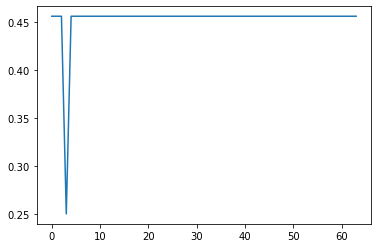

In [11]:
plt.plot(history.history['val_accuracy'])

In [12]:
np.max(history.history['val_accuracy'])

0.45652175

In [13]:
model_load = keras.models.load_model('NASNet_Transfer_Mask_2.h5')

In [14]:
model_load.evaluate(val_generator)

3/3 [==============================] - 10s 3s/step - loss: 1.5182 - accuracy: 0.4402


[1.5182052453358967, 0.4402174]

In [15]:
with open(f'{model_name}_history.pkl', 'wb') as fh:
    pickle.dump(history.history, fh)